In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Libraries

In [2]:
import utils
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.io import read_image
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import albumentations as A
import pickle as pkl
from UNET_model import UNET
from dataset import PetDataset, convert_color_to_class, remove_class_dimension


random.seed(42)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Data Preparation
In this step, I will be using the `datasets` python library to load both the image and mask together to make it easier for downstream tasks to process the data.
<br>

Once the dataset can be loaded, image augmentation will be performed with the `albumentations` python library to ensure the image size is consistent and our training data is robust.

In [3]:
# constants
TRAIN_IMAGE_DIR = "/teamspace/studios/this_studio/image-segmentation-cv/Dataset_filtered/TrainVal/color"
TRAIN_MASK_DIR = "/teamspace/studios/this_studio/image-segmentation-cv/Dataset_filtered/TrainVal/label"
TEST_IMAGE_DIR = "/teamspace/studios/this_studio/image-segmentation-cv/Dataset_filtered/Test/color"
TEST_MASK_DIR = "/teamspace/studios/this_studio/image-segmentation-cv/Dataset_filtered/Test/label"


In [4]:

def check_mask_uniqueness(img_path, mode, animal):
    image = Image.open(img_path).convert(mode)
    image_arr = np.array(image)
    print(f"type: {animal} mode: {mode} unique: {np.unique(image_arr)}")

check_mask_uniqueness(os.path.join(TRAIN_MASK_DIR, "Abyssinian_1.png"), "L", "cat")
check_mask_uniqueness(os.path.join(TRAIN_MASK_DIR, "american_bulldog_130.png"), "L", "dog")



type: cat mode: L unique: [  0  38 255]
type: dog mode: L unique: [  0  75 255]


In [5]:
# investigating the unique values in the segmentation mask for both training and test
def get_valid_masks(dataset_dir):
    classes = set()
    masks = os.listdir(dataset_dir)
    valid_masks = masks.copy()
    missing_masks = []

    for mask in masks:
        mask_img = read_image(os.path.join(dataset_dir, mask))
        unique_mask_values = mask_img.unique()

        # corrupted / missing mask
        if (len(unique_mask_values)) != 3:
            print(f"Missing mask: {mask}")
            missing_masks.append(mask)
            valid_masks.remove(mask)
            continue

        background = unique_mask_values[0].item()
        subject = unique_mask_values[1].item()
        boundary = unique_mask_values[2].item()

        classes.add(background)
        classes.add(subject)
        classes.add(boundary)

    print(f"Classes: {classes}")
    return valid_masks
    
train_valid_masks = get_valid_masks(TRAIN_MASK_DIR)
test_valid_masks = get_valid_masks(TEST_MASK_DIR)


Classes: {0, 1, 2, 255}
Classes: {0, 1, 2, 255}


# Data Loading

## Image Augmentations
Based on this [guide](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), since the models tend to receive a fixed size tensor, there are a few ways to achieve this.
- Resizing
- Cropping & Padding
<br />

The former way is straight forward but can lead to a loss in image quality, while the latter way is a good balance without compromising the image quality. As part of the first iteration, I will use the resizing augmentation.

In [6]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

transform = A.Compose([
    # A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, pad_if_needed=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),               
    A.Rotate(limit=(-40,40)),
    A.ElasticTransform(p=0.5),
    # A.ColorJitter(), 
    A.Normalize(), # does not affect mask
    A.ToTensorV2(transpose_mask=True),           
], seed=137, strict=True)
 


In [7]:
train_val_dataset = PetDataset(image_dir=TRAIN_IMAGE_DIR, mask_dir=TRAIN_MASK_DIR, valid_masks=train_valid_masks, transform=transform)
test_dataset = PetDataset(image_dir=TEST_IMAGE_DIR, mask_dir=TEST_MASK_DIR, valid_masks=test_valid_masks, transform=transform)

In [8]:
train_dataset, val_dataset = random_split(train_val_dataset, [0.8, 0.2])

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [10]:
train_image, train_mask = next(iter(train_dataloader))
print(f"Image batch shape: {train_image.size()}")
print(f"Mask batch shape: {train_mask.size()}")
# print(f"Mask unique values: {torch.unique(train_mask, dim=1)}")

Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


torch.Size([16, 256, 256])


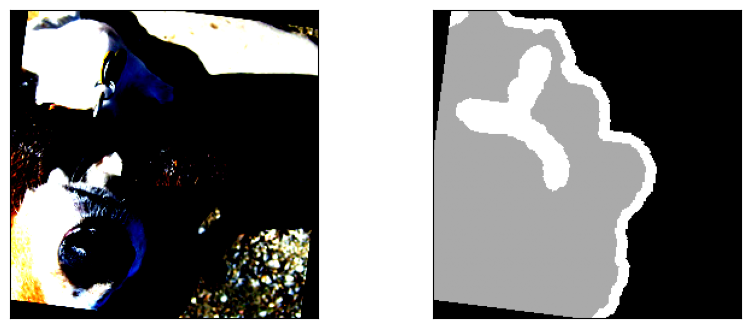

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
fig = plt.imshow(train_image[0].permute(1,2,0)) # squeeze cannot be used here since it only works if bs = 1
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.subplot(1,2,2)
print(f"{train_mask.size()}")
# convert mask back to single seg map
# mask = remove_class_dimension(train_mask[0])
mask = train_mask[0]
fig = plt.imshow(mask, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [12]:

# save the dataset into a pickle file to be loaded in
with open("Dataset_filtered/train.pkl", "wb") as f:
    pkl.dump(train_dataset, f)

with open("Dataset_filtered/val.pkl", "wb") as f:
    pkl.dump(val_dataset, f)

with open("Dataset_filtered/test.pkl", "wb") as f:
    pkl.dump(test_dataset, f)

In [13]:

with open("Dataset_filtered/train.pkl", "rb") as f:
    train_dataset = pkl.load(f)

with open("Dataset_filtered/val.pkl", "rb") as f:
    val_dataset = pkl.load(f)

with open("Dataset_filtered/test.pkl", "rb") as f:
    test_dataset = pkl.load(f)

In [14]:

DEVICE =  torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (images, masks) in enumerate(loop):
        # print(f"batch: {batch_idx} images: {images.size()} masks: {masks.size()}")
        images = images.to(device=DEVICE)
        masks = masks.long().to(device=DEVICE) # batch, class, height, width

        # forward
        with torch.amp.autocast(device_type="cpu"): # convolutions are much faster in lower_precision_fp
            predictions = model(images)
            loss = loss_fn(predictions, masks)

        # backward
        optimizer.zero_grad() # in pytorch grad are accumulated, zero it to only account for the current batch of training.
        scaler.scale(loss).backward() # scale the gradients to prevent them from being flushed to 0 due to computational limits
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item()) # additional data to display in the loading bar

In [15]:

BATCH_SIZE = 16
PIN_MEMORY = True
NUM_WORKERS = 4
LEARNING_RATE = 1e-5
LOAD_MODEL = False
NUM_EPOCHS = 50
DEVICE = "cuda"

model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = utils.get_loaders(
    train_dataset,
    val_dataset,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
)

if LOAD_MODEL:
    utils.load_checkpoint(torch.load("UNET_checkpoint.pth.tar"), model)

# utils.check_accuracy(val_loader, model, device=DEVICE)
scaler = torch.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename="UNET_checkpoint.pth.tar")

    # check accuracy
    utils.check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    # utils.save_predictions_as_imgs(
    #     val_loader, model, folder="saved_images", device=DEVICE
    # )

  0%|          | 0/184 [00:00<?, ?it/s]

100%|██████████| 184/184 [02:17<00:00,  1.34it/s, loss=1.17]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=1.31] 


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.948]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.998]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.81] 


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.798]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.859]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=1]    


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.637]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.809]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.729]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.63] 


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.74] 


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.873]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.729]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.777]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.802]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.745]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.82] 


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.673]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.551]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.807]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.575]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.541]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.72] 


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.7]  


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.523]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.716]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.576]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.512]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.562]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.462]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.542]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.579]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.558]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.448]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.805]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.38] 


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.502]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.43] 


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.499]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.446]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.432]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.477]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.39] 


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.473]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.435]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.444]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.491]


=> Saving checkpoint


100%|██████████| 184/184 [02:15<00:00,  1.36it/s, loss=0.339]


=> Saving checkpoint


In [15]:
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
import torch
# 直接加载 checkpoint 文件
checkpoint = torch.load("UNET_checkpoint.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [16]:
checkpoint_dict = torch.load("UNET_checkpoint.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(checkpoint_dict.keys())


dict_keys(['state_dict', 'optimizer'])


In [18]:
checkpoint = torch.load("UNET_checkpoint.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.to(DEVICE)  
model.eval()

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [20]:

def compute_metrics(pred, target, class_idx, eps=1e-6):
    # pred和target都是二维tensor（H, W），数值为类别索引
    pred_class = (pred == class_idx).float()
    target_class = (target == class_idx).float()
    intersection = (pred_class * target_class).sum()
    union = pred_class.sum() + target_class.sum() - intersection
    iou = intersection / (union + eps)
    dice = (2 * intersection) / (pred_class.sum() + target_class.sum() + eps)
    return iou.item(), dice.item()

total_iou_1, total_dice_1 = 0.0, 0.0
total_iou_2, total_dice_2 = 0.0, 0.0
num_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)  # targets应为(B, H, W)，每个像素值为类别0,1,2,3
        outputs = model(inputs)  # 假设输出为(B, num_classes, H, W)
        preds = torch.argmax(outputs, dim=1)  # (B, H, W)
        for pred, target in zip(preds, targets):
            iou1, dice1 = compute_metrics(pred, target, class_idx=1)
            iou2, dice2 = compute_metrics(pred, target, class_idx=2)
            total_iou_1 += iou1
            total_dice_1 += dice1
            total_iou_2 += iou2
            total_dice_2 += dice2
            num_samples += 1

avg_iou_1 = total_iou_1 / num_samples
avg_dice_1 = total_dice_1 / num_samples
avg_iou_2 = total_iou_2 / num_samples
avg_dice_2 = total_dice_2 / num_samples

print("类别1: 平均 IoU = {:.4f}, 平均 Dice = {:.4f}".format(avg_iou_1, avg_dice_1))
print("类别2: 平均 IoU = {:.4f}, 平均 Dice = {:.4f}".format(avg_iou_2, avg_dice_2))

类别1: 平均 IoU = 0.1849, 平均 Dice = 0.2201
类别2: 平均 IoU = 0.4852, 平均 Dice = 0.5544
